<a href="https://colab.research.google.com/github/AlexanderNeuwirth/CS5265_Project1/blob/main/CS5265_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 Definition
Created for CS5265 at Vanderbilt University

## Background

How much can be inferred about a product's nutritional attributes from what you can easily see on the product listing?

In other words, can you predict nutritional factors from brand, serving size, key words in the product title, and common ingredients?

This type of problem is of particular interest in a healthcare setting, where understanding a product in context of its nutritional components is necessary to make food purchasing decisions that are safe for specific medical needs. I often use similar data in my day-to-day work on healthcare procurement systems. It's interesting and potentially useful to explore possible relationships between different products, ingredients, and brands, and their corresponding nutritional features.

Due to wide available of government datasets and recipe sites with easily scraped online datasets, a fair amount of work has been done in this area. 

Random forest has been successfully applied to [predict processed vs unprocessed food](https://www.medrxiv.org/content/10.1101/2021.05.22.21257615v2.full), primarily from ingredient lists.

In Norway, large amounts of missing data in government databases led at least one group to attempt nutrition extraction [purely from natural language product descriptions](https://static1.squarespace.com/static/606f36b890215d7048ddaac0/t/62ed22f1ad65d913278ca3cb/1659708147387/PREDICTING+A+FOOD+PRODUCT%E2%80%99S+MISSING+NUTRITIONAL+VALUES+USING+MACHINE+LEARNING.pdf). Their method suffers in cases with poor quality descriptions, and has no mechanism to weight by token importance, but outperforms simple imputation methods.

Even nutrition prediction from raw images has seen [some success](https://arxiv.org/pdf/2011.01082.pdf?from=article_link), with confirmation by at least one [subsquent review experiment](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8787663/) that prepared new samples with known nutrition details.

No published method seems to approach this problem using simple feature engineering on the description and ingredient list, seeking to predict nutrient attributes. That is the gap I seek to investigate in this work.

## Project Description

This project will attempt to perform binary classification on whether products meet a "low fat" dietary classification using only those higher-level features like brand, serving size, key words in the product title, and common ingredients.

This project uses the [USDA Branded Food Products Dataset](https://data.nal.usda.gov/dataset/usda-branded-food-products-database). This data contains detailed ingredient listings, serving amounts, and nutrient quantities for about 250,000 branded and private-label food products sold in the United States. All entries are laboratory results with thorough human review and are held to high data quality standards by law, as the precise values inform many clinical and regulatory policy enforcement.

Some raw data fields include:
* **Product Title**: A text description
* **Serving Size**: Continuous-valued numerical usage quantity (normalized to either grams or milliliters)
* **Nutritionals**: Continuous-valued numerical nutrient quantities (by weight)
* **Ingredients**: A comma-separated list of ingredients (as strings)

Some easily derived processed data fields could include:
* **Total Calories**: by summing simple benchmark multipliers of carbs, proteins, and fats
* **Low Fat**: by thresholding fat total against the conventional threshold of 3 grams per serving
* **Binary "Contains Ingredient" Features**: by filtering on the presence of common ingredient strings in the string ingredient column

If successful in this task and similar binary classification tasks of interest, it may be appropriate to attempt regression on more complex target variables (like calorie count, grams of fat, or grams of fiber).

Example Input Features:
* Serving size (continuous)
* Brand (categorical)
* Key terms extracted from description (e.g. "Healthy", "Diet", "Organic") (binary)
* Presence of specific ingredient terms, extracted from ingredient list (e.g. "Butter", "Corn Syrup", "Sugar"

Example Output Features:
* Low-Fat (binary classification)
* *(Aspirational)* Calorie count (integer regression)

## Performance Metric
For the initial goal of binary low-fat classification, an appropriate performance metric is simple percent accuracy.
If accuracy is low, precision and recall will be useful metrics to determine any bias in the error. If classes are heavily unbalanced (e.g. there are relatively few low-fat products) it may be appropriate to use an accuracy metric that reflects both precision and recall, like F1 score.

Mathematical formulations of all of the above metrics are provided below, where T and F stand for "True" and "False", and P and N stand for "Positive" and "Negative."

$$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$$
$$Precision = \frac{TP}{TP+FP}$$
$$Recall = \frac{TP}{TP+FN}$$
$$F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$$


For the stretch goal of calorie count regression, an appropriate performance metric may be mean absolute error (MAE). (Given below where x is the actual value, y is the predicted value, and D is the number of data points being evaluated.)

$$\sum_{i=1}^{D}|x_i-y_i|$$

This would be easily interpretable as how far off the model's predictions are from the actual number of calories (as opposed to mean squared error, which would be less readily interpretable.)

## Basic EDA
Key questions:

1. Are full macronutrient details available for each product in the data? If not, what % of coverage do we have?
2. Are units standardized for both servings and nutrients? If not, how difficult will standardization be?
3. How much diversity of manufacturer/brand types exists in the data? Including count, frequent terms, and general recognizability of names in a random sample.
4. What range of serving sizes exists in the data? What are the extreme outliers?

### Google Drive Connection

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls drive/MyDrive/food_nutrition_data/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BFPD_Doc.pdf			 Nutrients.csv	Serving_size.csv
Derivation_Code_Description.csv  Products.csv


### Data Loading

In [2]:
import pandas as pd

products_df = pd.read_csv("drive/MyDrive/food_nutrition_data/Products.csv", low_memory=False)
nutrients_df = pd.read_csv("drive/MyDrive/food_nutrition_data/Nutrients.csv", low_memory=False)
servings_df = pd.read_csv("drive/MyDrive/food_nutrition_data/Serving_size.csv", low_memory=False)

### Nutrient Joining

In [3]:
coverage = products_df.NDB_Number.isin(nutrients_df.NDB_No).value_counts()
print(f"{round(coverage[1]*100/coverage.sum(), 2)}% of products have some nutrient info")

99.48% of products have some nutrient info


In [4]:
# Verify that each nutrient code corresponds to a unique name
print(nutrients_df.groupby("Nutrient_Code").Nutrient_name.nunique().value_counts())

1    95
Name: Nutrient_name, dtype: int64


In [5]:
# Find nutrients that appear at least ~10% of the time
occurence_counts = nutrients_df.Nutrient_name.value_counts()
occurence_counts[(occurence_counts > nutrients_df.NDB_No.nunique() * 0.1)]

Carbohydrate, by difference           237635
Total lipid (fat)                     237559
Protein                               237432
Sodium, Na                            236887
Energy                                228500
Sugars, total                         223394
Fatty acids, total saturated          205694
Cholesterol                           202966
Fiber, total dietary                  198171
Iron, Fe                              196981
Calcium, Ca                           196065
Fatty acids, total trans              194801
Vitamin C, total ascorbic acid        178809
Vitamin A, IU                         174501
Potassium, K                           53337
Fatty acids, total monounsaturated     33822
Fatty acids, total polyunsaturated     33799
Vitamin D                              27668
Name: Nutrient_name, dtype: int64

In [6]:
# Drop nutrients that don't occur that often. These seem to be manually entered, and many apply to only a handful of products
nutrients_to_drop = occurence_counts[(occurence_counts < nutrients_df.NDB_No.nunique() * 0.1)].index
nutrients_df = nutrients_df[~nutrients_df.Nutrient_name.isin(nutrients_to_drop)]

In [7]:
# Verify that we don't need to normalize output UOMs since they are consistent for a given nutrient (no mixing mg and g)
print(f"Maximium unique units of measure per nutrient: {nutrients_df.groupby('Nutrient_name').Output_uom.nunique().max()}")

Maximium unique units of measure per nutrient: 1


In [8]:
# Roll up nutrients df of product-nutrient pairs into nutrient feature columns
nutrients_pivot = nutrients_df.pivot_table(values='Output_value', index=nutrients_df['NDB_No'], columns='Nutrient_name', aggfunc='first')
nutrients_pivot.head()

Nutrient_name,"Calcium, Ca","Carbohydrate, by difference",Cholesterol,Energy,"Fatty acids, total monounsaturated","Fatty acids, total polyunsaturated","Fatty acids, total saturated","Fatty acids, total trans","Fiber, total dietary","Iron, Fe","Potassium, K",Protein,"Sodium, Na","Sugars, total",Total lipid (fat),"Vitamin A, IU","Vitamin C, total ascorbic acid",Vitamin D
NDB_No,,,,,,,,,,,,,,,,,,
45001524,50.0,35.00,25.0,200.0,NaN,NaN,3.75,0.0,0.0,0.0,NaN,2.5,75.0,30.00,6.25,0.0,3.0,NaN
45001528,0.0,43.24,0.0,162.0,NaN,NaN,0.00,0.0,0.0,0.0,NaN,0.0,703.0,37.84,0.00,270.0,9.7,NaN
45001529,0.0,41.18,0.0,176.0,NaN,NaN,0.00,0.0,0.0,0.0,NaN,0.0,676.0,35.29,0.00,0.0,0.0,NaN
45001530,0.0,34.29,0.0,143.0,NaN,NaN,0.00,0.0,0.0,0.0,NaN,0.0,971.0,28.57,0.00,0.0,0.0,NaN
45001531,0.0,45.95,0.0,189.0,NaN,NaN,0.00,0.0,0.0,0.0,NaN,0.0,757.0,43.24,0.00,0.0,0.0,NaN


In [9]:
# Merge nutrient columns to original product data
df = pd.merge(products_df, nutrients_pivot, left_on="NDB_Number", right_on="NDB_No", how="left")

### Serving Size Joining

In [10]:
# Verify servings lines are unique (we don't need to deal with conflicts, etc)
print(f"Max unique serving definitions per product: " +
      f"{servings_df.NDB_No.value_counts().max()}")

Max unique serving definitions per product: 1


In [11]:
df = pd.merge(df, servings_df, left_on="NDB_Number", right_on="NDB_No", how="left")

In [12]:
df.head()

,NDB_Number,long_name,data_source,gtin_upc,manufacturer,date_modified,date_available,ingredients_english,"Calcium, Ca","Carbohydrate, by difference",...,Total lipid (fat),"Vitamin A, IU","Vitamin C, total ascorbic acid",Vitamin D,NDB_No,Serving_Size,Serving_Size_UOM,Household_Serving_Size,Household_Serving_Size_UOM,Preparation_State
0,45001524,MOCHI ICE CREAM BONBONS,LI,019022128593,"G. T. Japan, Inc.",2017-11-15 19:19:38,2017-11-15 19:19:38,"ICE CREAM INGREDIENTS: MILK, CREAM, SUGAR, STR...",50.0,35.00,...,6.25,0.0,3.0,NaN,45001524.0,40.0,g,1.0,PIECE,NaN
1,45001528,CHIPOTLE BARBECUE SAUCE,LI,5051379043735,FRESH & EASY,2018-04-26 17:23:31,2018-04-26 17:23:31,"WATER, SUGAR, TOMATO PASTE, MOLASSES, DISTILLE...",0.0,43.24,...,0.00,270.0,9.7,NaN,45001528.0,37.0,g,2.0,Tbsp,NaN
2,45001529,HOT & SPICY BARBECUE SAUCE,LI,5051379009434,FRESH & EASY,2018-04-26 18:17:37,2018-04-26 18:17:37,"SUGAR, WATER, DISTILLED VINEGAR, TOMATO PASTE,...",0.0,41.18,...,0.00,0.0,0.0,NaN,45001529.0,34.0,g,2.0,Tbsp,NaN
3,45001530,BARBECUE SAUCE,LI,5051379019969,FRESH & EASY,2018-04-26 17:24:00,2018-04-26 17:24:00,"TOMATO PUREE (WATER, TOMATO PASTE), SUGAR, DIS...",0.0,34.29,...,0.00,0.0,0.0,NaN,45001530.0,35.0,g,2.0,Tbsp,NaN
4,45001531,BARBECUE SAUCE,LI,5051379009526,FRESH & EASY,2018-04-26 17:47:41,2018-04-26 17:47:41,"SUGAR, DISTILLED VINEGAR, WATER, TOMATO PASTE,...",0.0,45.95,...,0.00,0.0,0.0,NaN,45001531.0,37.0,g,2.0,Tbsp,NaN


### EDA Question 1: Missing Macronutrients

In [13]:
missing_fat = df["Total lipid (fat)"].isna()
missing_protein = df["Protein"].isna()
missing_carbs = df["Carbohydrate, by difference"].isna()

In [14]:
# Confirming that "0" data points exist - the NAs likely account for actual
# missing data, not "fat free" data
(df["Total lipid (fat)"] == 0).sum()

75947

In [15]:
def format_percent(s):
  return (f"{round((s.sum()*100)/len(df), 2)}%")

print(f'{format_percent(missing_fat)} are missing fat data')
print(f'{format_percent(missing_protein)} are missing protein data')
print(f'{format_percent(missing_carbs)} are missing carbs data')

print(f'{format_percent((missing_fat | missing_protein | missing_carbs))} are missing at least one type')
print(f'{format_percent((missing_fat & missing_protein & missing_carbs))} are missing all types')

0.64% are missing fat data
0.69% are missing protein data
0.61% are missing carbs data
0.83% are missing at least one type
0.54% are missing all types


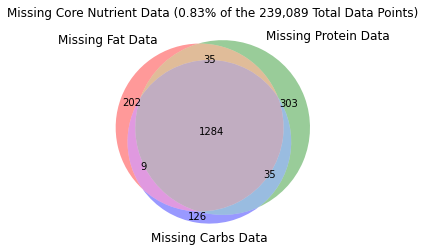

In [16]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

set1 = set(df[missing_fat].index)
set2 = set(df[missing_protein].index)
set3 = set(df[missing_carbs].index)

venn3([set1, set2, set3], ('Missing Fat Data', 'Missing Protein Data', 'Missing Carbs Data'))
plt.title("Missing Core Nutrient Data (0.83% of the 239,089 Total Data Points)")
plt.show()

### EDA Question 2: Unit Standardization

In [17]:
# We actually already needed to investigate this when joining the nutrient data,
# to make sure it was appropriate to roll up the values into columns without
# normalizing into units of measure.
print(f"Maximium unique units of measure per nutrient: " +
      f"{nutrients_df.groupby('Nutrient_name').Output_uom.nunique().max()}")

Maximium unique units of measure per nutrient: 1


Text(0, 0.5, 'Total Occurences')

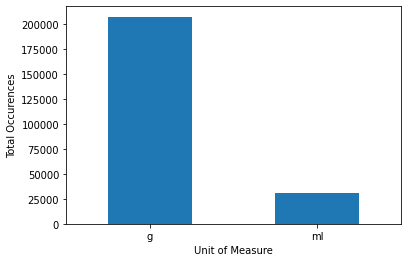

In [18]:
# Now to check if servings are standardized..
df.Serving_Size_UOM.value_counts().plot(kind="bar")
plt.xticks(rotation=0)
plt.xlabel("Unit of Measure")
plt.ylabel("Total Occurences")

In [19]:
percent_grams = round(df.Serving_Size_UOM.value_counts()[0]/df.Serving_Size_UOM.count()*100, 2)
print(f"{percent_grams}% of products have serving size in grams")

87.0% of products have serving size in grams


In [20]:
# Let's look at a sample of products in ml to see if we can use the density
# of water as a good approximation to convert them to grams...
df[df.Serving_Size_UOM == "ml"].long_name.sample(25)

126207                                           CREAM BARS
112378                           ARTESIAN WATER FROM NORWAY
75689                                          SMOOTHIE MIX
148671                 PEDIALYTE MIXED FRUIT 1 LITER BOTTLE
189605                        SUNKIST, PINK LEMONADE, LEMON
142102                             CHIANTI RED WINE VINEGAR
92396                          REDUCED SODIUM CHICKEN BROTH
109263                         BRAISED BEEF & MUSHROOM SOUP
194368                                     LIGHT MAYONNAISE
162171                                        FAT FREE MILK
161507                                                 SODA
146376             SPORT ELECTROLYTES + VITAMIN B3, B6, B12
123437                                     PREMIUM LEMONADE
211003                                     SWEET & SOUR MIX
224831                   NATURALLY FLAVORED SPARKLING WATER
144183                    SUN TROPICS, MANGO PREMIUM NECTAR
224813                             ORGAN

Water has a density of 1 g/ml

Based on web searches:
* Whole milk has a density of about 1.04 g/ml
* Eggnog has a density of about 1.07 g/ml
* Salsa has a density of about 1.2 g/ml
* Honey has a density of about 1.3 g/ml
* Oil has a density of about 0.7 g/ml

I was unable to find anything more extreme than these examples in any of several searches, so we could assume a 1 ml = 1 g conversion with only about 30% error in most reasonable cases

### EDA Question 3: Diversity of Manufacturer/Brand Types

In [21]:
# Random sample to get a sense of typical values.
# Many organizations are instantly recognizable.
df.manufacturer.sample(25)

50229                            Idahoan Foods, LLC
125916                              Supervalu, Inc.
201216                              Supervalu, Inc.
186204                 Planters Life Savers Company
229155    Nestle Waters North America Inc./ice Mtn.
121956                Mrs. Fields Famous Brands LLC
110601                        Nilda's Desserts Ltd.
234291                                     OBERWEIS
135521                              SIMPLY BALANCED
167703               F.B. Purnell Sausage Co., Inc.
83052                      Whole Foods Market, Inc.
214113                        Wal-Mart Stores, Inc.
18503                                  Meijer, Inc.
96427                                  FRESH FROZEN
56745                                Conagra Brands
184772                                      Raley's
237128                           H.J. Heinz Company
55545              Unilever Bestfoods North America
215004                               Glencourt Inc.
71477       

In [22]:
# The top manufacturers: all big-label retail food grocers (Wal-Mart, Meijer, Kroger),
# manufacturers/distributors (General Mills, Supervalu), and GPOs (Topco)
df.manufacturer.value_counts().head(10)

Wal-Mart Stores, Inc.       4546
Meijer, Inc.                3855
Target Stores               3771
The Kroger Co.              3476
Safeway, Inc.               3194
Topco Associates, Inc.      2905
Supervalu, Inc.             2771
Hy-Vee, Inc.                2667
Weis Markets, Inc.          2207
GENERAL MILLS SALES INC.    1966
Name: manufacturer, dtype: int64

In [23]:
# normalize case and remove special characters
clean_manufacturer_names = df.manufacturer.str.replace("[^a-zA-Z ]", "", regex=True).str.lower()
# collapse multiple spaces
clean_manufacturer_names = clean_manufacturer_names.str.replace("\s+", " ", regex=True)
# split into token lists
clean_manufacturer_tokens = clean_manufacturer_names.str.split(' ', expand=True).stack()

In [24]:
clean_manufacturer_tokens.value_counts().head(10)

inc        106187
foods       28118
company     22667
llc         18818
co          14268
stores      12276
the         11544
food        10304
markets      8630
usa          6791
dtype: int64

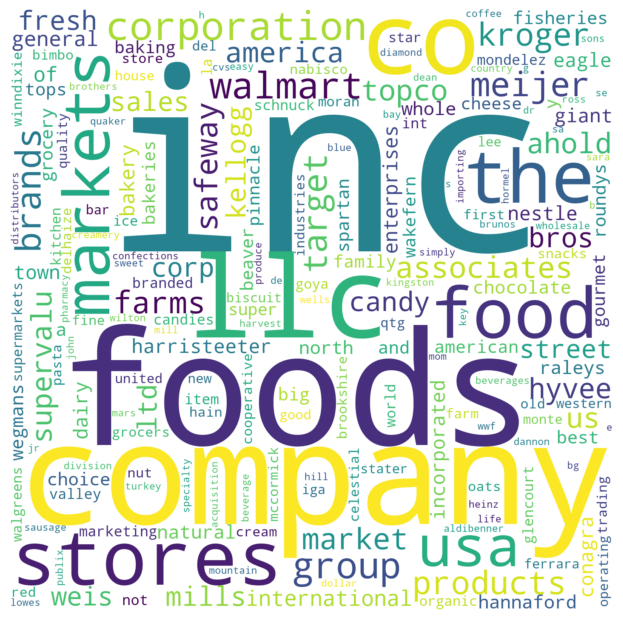

In [25]:
from wordcloud import WordCloud
wordcloud = WordCloud(
    width = 1600, height = 1600, background_color ='white', min_font_size = 10)
wordcloud.generate_from_frequencies(clean_manufacturer_tokens.value_counts())
fig=plt.figure(figsize=(12,8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### EDA Question 4: Serving Size Range and Outliers

count    206950.000000
mean         61.227138
std          58.474537
min           0.015000
25%          28.000000
50%          40.000000
75%          85.000000
max        2808.000000
Name: Serving_Size, dtype: float64

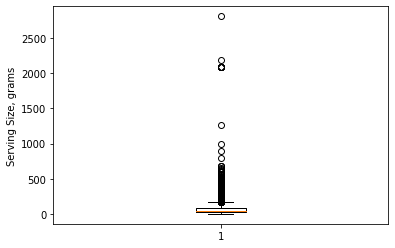

In [26]:
# Boxplot: By-weight products
g_sizes = df[df.Serving_Size_UOM == 'g'].Serving_Size.dropna()
plt.boxplot(g_sizes)
plt.ylabel("Serving Size, grams")

# Simple summary stats
g_sizes.describe()

count    30925.000000
mean       202.599058
std        141.815038
min          0.120000
25%         30.000000
50%        240.000000
75%        240.000000
max       3750.000000
Name: Serving_Size, dtype: float64

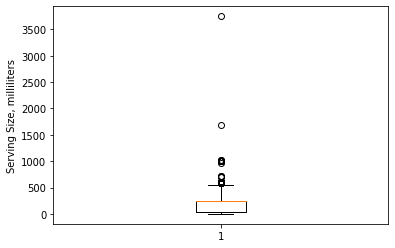

In [27]:
# Boxplot: By-volume products
ml_sizes = df[df.Serving_Size_UOM == 'ml'].Serving_Size.dropna()
plt.boxplot(ml_sizes)
plt.ylabel("Serving Size, milliliters")

# Simple summary stats
ml_sizes.describe()

In [28]:
# Largest serving sizes
df.sort_values("Serving_Size", ascending=False).head(15)

,NDB_Number,long_name,data_source,gtin_upc,manufacturer,date_modified,date_available,ingredients_english,"Calcium, Ca","Carbohydrate, by difference",...,Total lipid (fat),"Vitamin A, IU","Vitamin C, total ascorbic acid",Vitamin D,NDB_No,Serving_Size,Serving_Size_UOM,Household_Serving_Size,Household_Serving_Size_UOM,Preparation_State
200374,45330005,ORGANIC CHOPPED TOMATOES,LI,677294998186,ORGANICO BELLO,2017-10-13 18:14:18,2017-10-13 18:14:18,"ORGANIC CHOPPED TOMATOES, ORGANIC TOMATO PUREE.",1.0,0.19,...,0.00,NaN,0.4,0.0,45330005.0,3750.0,ml,0.50,cup,NaN
56039,45133744,ACT II Butter Lovers Popcorn,GDSN,00076150232530,ConAgra Foods Inc.,2018-02-12 15:49:47,2018-04-26 10:20:47,"Popping Corn, Palm Oil, Salt, Less than 2% of:...",0.0,0.68,...,0.14,0.0,0.0,NaN,45133744.0,2808.0,g,2.00,tbsp (30g) unpopped (makes about 4.5 cups popped),UNPREPARED
55598,45130180,ACT II Butter Lovers Popcorn,GDSN,00076150232547,ConAgra Foods Inc.,2017-11-30 14:43:32,2018-04-26 10:20:47,"Popping Corn, Palm Oil, Salt, Less than 2% of:...",0.0,0.87,...,0.18,0.0,0.0,NaN,45130180.0,2184.0,g,2.00,tbsp (30g) unpopped (makes about 4.5 cups popped),UNPREPARED
99287,45187513,"SWEET ACTION, ICE CREAM, VEGAN STRAWBERRY",LI,751570510498,Sculatti I.F.S.,2017-07-14 18:37:31,2017-07-14 18:37:31,"ORGANIC SOY MILK, ORGANIC COCONUT CREAM (COCON...",3.0,1.82,...,0.57,5.0,0.7,NaN,45187513.0,2091.0,g,4.00,ONZ,NaN
99288,45187514,"SWEET ACTION ICE CREAM, ICE CREAM, VEGAN COCON...",LI,751570510511,Sculatti I.F.S.,2017-07-14 18:37:31,2017-07-14 18:37:31,"ORGANIC SOY MILK, ORGANIC COCONUT CREAM (COCON...",4.0,1.82,...,0.77,5.0,0.1,NaN,45187514.0,2091.0,g,4.00,ONZ,NaN
83685,45169021,"SWEET ACTION ICE CREAM, ICE CREAM, VEGAN COFFE...",LI,751570510467,Sculatti I.F.S.,2017-07-14 18:01:22,2017-07-14 18:01:22,"ORGANIC SOY MILK, ORGANIC COCONUT CREAM (COCON...",3.0,1.82,...,0.67,5.0,0.1,NaN,45169021.0,2091.0,g,4.00,ONZ,NaN
99157,45187353,"SWEET ACTION, ICE CREAM, VEGAN MINT CHIP",LI,700621453444,Disk Technologies Corporation,2018-01-20 03:51:49,2018-01-20 03:51:49,"ORGANIC SOY MILK, ORGANIC COCONUT CREAM (COCON...",3.0,1.87,...,0.77,24.0,0.1,NaN,45187353.0,2091.0,g,4.00,ONZ,NaN
83745,45169100,"SWEET ACTION, ICE CREAM, VEGAN CINNAMON ROLL",LI,799491898615,Reese Orchards,2017-07-14 18:01:51,2017-07-14 18:01:51,"ORGANIC SOY MILK, ORGANIC COCONUT CREAM (COCON...",4.0,2.58,...,0.81,5.0,0.1,NaN,45169100.0,2091.0,g,4.00,ONZ,NaN
99286,45187512,"SWEET ACTION, ICE CREAM, VEGAN COOKIES + CREAM",LI,751570510474,Sculatti I.F.S.,2017-10-31 14:57:51,2017-10-31 14:57:51,"ORGANIC SOY MILK, ORGANIC COCONUT CREAM (COCON...",3.0,1.87,...,0.72,5.0,0.1,NaN,45187512.0,2091.0,g,4.00,ONZ,NaN
83509,45168774,"SWEET ACTION, ICE CREAM, VANILLA BEAN",LI,700621453383,Disk Technologies Corporation,2017-07-14 18:00:41,2017-07-14 18:00:41,"ORGANIC SOY MILK, ORGANIC COCONUT CREAM (COCON...",3.0,1.63,...,0.67,5.0,0.1,NaN,45168774.0,2091.0,g,4.00,ONZ,NaN


There is clearly some bad data at the top. Careful analysis indicates that these are the result of calculation errors:
1. Popcorn: the entries indicate that 2 tbsp of kernels yield over 2 kilograms of popped corn. This seems to be the result of a bad volume-to-weight conversion. My attempt to replicate their bad calculation leads to a similar value to the one they achieve, within about 30%.
2. Vegan ice cream: the serving size seems to be the result of a bad conversion of the "ONZ" label into weight. Either ONZ means something other than ounces in this context, or the volume of the container is not fully taken up with the product.
3. There are some other high-serving products (potatoes, etc) that seem to have been incorrectly manually converted. For example: the imperial to metric conversion is off by about a factor of ten

After these few bad data points, the data is dominated by reasonable high-volume liquids like bottled water and baby formula.

In [29]:
# Smallest serving sizes
df.sort_values("Serving_Size", ascending=True).head(5)

,NDB_Number,long_name,data_source,gtin_upc,manufacturer,date_modified,date_available,ingredients_english,"Calcium, Ca","Carbohydrate, by difference",...,Total lipid (fat),"Vitamin A, IU","Vitamin C, total ascorbic acid",Vitamin D,NDB_No,Serving_Size,Serving_Size_UOM,Household_Serving_Size,Household_Serving_Size_UOM,Preparation_State
177031,45283500,NO CALORIE SWEETENER TABLETS,LI,722776001448,SPLENDA,2018-01-19 21:51:00,2018-01-19 21:51:00,"LACTOSE (FROM MILK), SUCRALOSE, CROSCARMELLOSE...",NaN,0.0,...,0.0,NaN,NaN,NaN,45283500.0,0.015,g,1.0000,TABLET,NaN
27872,45060333,SAFFRON THREADS,LI,016291441491,Morton Bassett Inc.,2017-07-27 03:37:35,2017-07-27 03:37:35,NaN,NaN,0.0,...,0.0,NaN,NaN,NaN,45060333.0,0.025,g,0.1250,tsp,NaN
83666,45168991,"NUNATURALS, LOSWEET PREMIUM NATURAL SWEETNER",LI,739223001876,"Nunaturals, Inc.",2018-04-11 07:08:02,2018-04-11 07:08:02,LO HAN GUO (MONK FRUIT) EXTRACT.,NaN,0.0,...,0.0,NaN,NaN,NaN,45168991.0,0.035,g,0.0150,tsp,NaN
99262,45187482,NUSTEVIA REB99 PREMIUM NATURAL SWEETENER,LI,739223006000,"Nunaturals, Inc.",2017-07-14 18:37:23,2017-07-14 18:37:23,STEVIA EXTRACT (STEVIA REBAUDIANA) (LEAF).,NaN,0.0,...,0.0,NaN,NaN,NaN,45187482.0,0.035,g,0.0156,tsp,NaN
163168,45268188,STEVIA SWEETENER TABLETS,LI,716123128407,"United American Industries,Inc",2018-01-31 18:01:47,2018-01-31 18:01:47,"CELLULOSE, ORGANIC STEVIA LEAF EXTRACT, SILICA",NaN,0.0,...,0.0,NaN,NaN,NaN,45268188.0,0.043,g,1.0000,TABLET (EQUAL TO 100 TSP. OF SUGAR),NaN


The extreme lows seem rather unremarkable: sweeteners, seasonings, etc., that would be expected to have an extremely low serving size.

In [30]:
# Sample of typical serving sizes
df[["long_name", "Serving_Size", "Serving_Size_UOM"]].sample(10)

,long_name,Serving_Size,Serving_Size_UOM
230283,Starbucks Caramel Medium Roast Latin American ...,330.0,ml
42476,"SHIRAKIKU, TEMPURA BATTER MIX",30.0,g
48667,BIG CONE REDUCED FAT ICE CREAM,93.0,g
189206,Old El Paso Cheesy Mexican Rice,73.0,g
63350,CHRISTMAS JUJU SANTAS,43.0,g
61899,"SPARTAN, VALENTINE TREATS SOURS, CHERRY",40.0,g
113208,SLICED BRUSSELS SPROUTS,85.0,g
48001,FRENCH ONION DIP,33.0,g
13850,ORIGINAL WHIPPED TOPPING,9.0,g
44512,GELATIN DESSERT,3.0,g


These all seem reasonable, with a rough benchmark of 1 gram per potato chip for reference.

### Additional EDA and Cleaning

#### Extract "Low Fat"

Technically, the definition for "Low fat" depends on whether you're assessing snacks or main dishes/meals. The requirements for a main dish are stricter (max 3 g per 100 g rather than max 3 g per 50 g and a max calorie ratio requirement for other food items.)

For this project, since there's no field in the data to indicate whether a food is legally a main course, we will take a simple, relatively strict definition of 3 g of fat per 100 g indicating a low fat product.

In [31]:
# Low fat is defined by limiting the fat to 3 g per serving
# Nutrition facts are already normalized to 100 gram servings
df["low_fat"] = (df["Total lipid (fat)"] < 3)

In [32]:
print("Low fat foods:")
print(df[df.low_fat == True].long_name.sample(5))

print("\nHigh fat foods:")
print(df[df.low_fat == False].long_name.sample(5))

Low fat foods:
190194                          SODA
205966                HEARTS OF PALM
229563             26/35 CPTO SHRIMP
99534     BAKLAVA BAKERY, PITA BREAD
197806                         SAUCE
Name: long_name, dtype: object

High fat foods:
85386          ROUNDY'S, CREME CAKE, COCONUT SOUR CREAM
149001                                  LIGHT ICE CREAM
116878                              MILK CHOCOLATE ROSE
74396     SOUTHERN STYLE NUTS, BUTTERCREAM PECAN PIECES
85823                     BIG Y, 100% WHOLE WHEAT BREAD
Name: long_name, dtype: object


It's reassuring that most of the low fat foods are clearly low fat, and the high fat foods tend to be obviously less healthy.

### Extract Calories Per Gram
Let's make sure that we can get the target variable ("Calories Per Gram") and that it looks reasonable for different products.

In [33]:
df['calories_per_gram'] = df['Energy'] / 100 # Nutrients file is normalized to 100 gram portions

In [34]:
# We can't predict on values that don't have a target variable defined
df = df.dropna(subset=['calories_per_gram'])

In [35]:
df[['long_name', 'calories_per_gram']].sample(10)

,long_name,calories_per_gram
88266,"HANNAFORD, PROVOLONE CHEESE",3.81
171807,PLUM BUTTER,2.33
102394,PANCAKE & WAFFLE MIX,3.61
45284,LEG STYLE CRAB SELECT,1.00
23808,PREMIUM BLACK TEA BLEND,0.00
209509,PROTEIN BAR,3.80
102052,2% REDUCED FAT MILK,0.54
210416,"PRIVATE SELECTION, ROASTED RED PEPPER HUMMUS",2.14
33889,ORGANIC GOLDEN FLAXSEED SPREAD WITH DATES AND ...,0.95
92402,"ACME FRESH MARKET, COLBY JACK CHEESE",3.57


Several of these were also confirmed with external online sources, and these numbers seem consistent with other trusted values.

#### Deal with Missing Serving Sizes
Some serving sizes are missing. Let's figure out how to fix that

In [36]:
# Check how many values are missing
df.Serving_Size.isna().sum()

17

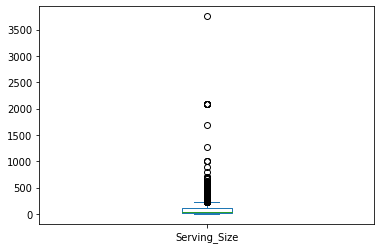

In [37]:
df.Serving_Size.plot(kind="box")

There are very few missing serving sizes. The distribution is very uneven, possibly exponentially distributed, so taking a simple mean as an imputation is probably not a good idea. Additionally, there seems to be a pattern where entries with key missing values in these tables are missing other data.

Let's examine the cases that have no serving size specified

In [38]:
df[df.Serving_Size.isna()].head(3)

,NDB_Number,long_name,data_source,gtin_upc,manufacturer,date_modified,date_available,ingredients_english,"Calcium, Ca","Carbohydrate, by difference",...,"Vitamin C, total ascorbic acid",Vitamin D,NDB_No,Serving_Size,Serving_Size_UOM,Household_Serving_Size,Household_Serving_Size_UOM,Preparation_State,low_fat,calories_per_gram
132081,45224108,"NATURADE, GRASS FED WHEY PROTEIN BOOSTER, CHOC...",LI,079911030048,"Prevention, LLC",2018-06-07 03:03:48,2018-06-07 03:03:48,"WHEY PROTEIN CONCENTRATE, CHICORY INULIN, COCO...",238.0,28.57,...,0.0,NaN,45224108.0,NaN,g,1.0,PACKET,NaN,False,3.81
202444,45332332,"SUNFOOD, RAW ORGANIC PROTEIN POWDER, CHOCOLATE",LI,803813100284,Sunfood LLC,2018-06-05 05:34:30,2018-06-05 05:34:30,ORGANIC SPROUTED WHOLE GRAIN BROWN RICE PROTEI...,179.0,21.43,...,6.1,NaN,45332332.0,NaN,g,1.0,SCOOP,NaN,False,4.00
202486,45332424,"NATURADE, PEA PROTEIN VEGAN SHAKE, VANILLA",LI,079911026065,"Prevention, LLC",2018-06-09 06:04:38,2018-06-09 06:04:38,"PEA PROTEIN ISOLATE, ORGANIC CANE SUGAR, INULI...",0.0,22.22,...,0.0,NaN,45332424.0,NaN,g,1.0,PACKET,NaN,False,3.89


All cases with missing serving size (subset shown above) seem to be protein powder. This seems sufficiently out of the target of this model (predicting food values) that I'm content to discard these bad entries.

In [39]:
# Drop protein powders with no serving size since they aren't really food
df = df.dropna(subset=["Serving_Size"])

### EDA Summary
* Missing Macronutrients: About 99.2% of the data has complete macronutrients. For simplicity, we will likely discard the remainder of the data, since it seems likely to be incomplete or inaccurate in other ways too.
* Unit Standardization: Nutrient information is completely standardized already. Serving size units are standardized by either weight or volume. The majority of the data (87%) is expressed by weight. We could discard the by-volume data: however, intuition and a careful analysis of the liquid data indicates that approximating 1 ml = 1 gram would be appropriate for most products, since food priced by volume is typically water, syrup, or oil based. An analysis of several such products, including extreme examples like cream, salsa, honey and oil, all fell within about 30% of a 1 g/ml density, likely close enough to proceed with assuming this conversion.
* Diversity of Manufacturer/Brand Types: The main contributers to the dataset are from US national food retailers (like Walmart and Kroger), food GPOs, and major manufacturers. There seems to be a long tail of smaller brands and manufacturers: additionally, some larger manufacturers seem to be obfuscating their contributions (intentionally or otherwise) by using subbrand names or adding random numbers to their brand names.
* Serving size range and outliers: The data ranges between reasonable extremes of food servings: from sub-0.1-gram servings of seasonings and sweeteners to 1-liter servings of water and baby formula. There are a couple obviously bad data points at the extreme high end, with possible explanations enumerated within the analysis above. A cursory overview of the lower extremes, most upper extremes, and a totally random sample of foods all seem reasonable.
* Low-fat output: low fat can be easily extracted with a threshold of < 3 grams of fat per 100 grams of food. Results seem consistent with what one would normally expect as low fat.
* Calories per gram output: Calories can also be easily extracted directly from nutrition facts. These extracted numbers look consistent with other online sources and make intuitive sense.
* Missing serving sizes: The rows with missing serving sizes all seem to correspond to protein powder products. These were omitted from the dataset, since they seem relatively far out of domain for a food classification model.

##Feature Engineering
### Final Feature List
There are 101 final input features used by this model.

Features 1-50: Boolean columns indicating whether each of the most common product name tokens occur in this specific product's description. Boolean flags indicating whether the token is present in the description or not.
*Examples: 'name_contains_cheese', 'name_contains_chocolate', 'name_contains_organic'*

Features 51-100: The ingredient index of the most common tokens in ingredient names (with 0 being the largest ingredient by volume, with higher numbers falling later in the list. -1 indicates the ingredient isn't present) *Examples: 'ingredient_index_natural and artificial flavor', 'ingredient_index_brown sugar', 'ingredient_index_artificial flavor', 'ingredient_index_eggs'*

Feature 101: Serving Size, in grams.

(Effectively, we build a small-vocabulary bag of words for the name, and create a new feature to interpret ingredients)


### Feature Engineering Overview
As initally planned, this project will require particularly heavy feature engineering, since the input data is largely unstructured, text based data.

The primary goals wil be:
* Extract usable features from the ingredients list (likely of binary "has or doesn't have" the ingredient, and possibly another encoding that captures how high the ingredient is on the ingredient list (like index on the ingredient list, normalized by number of ingredients.)
* Extract usable features from the product name. (similar to the previous with common phrases and key words, like "Fat Free", "Diet", "Snack", etc.)

There will also be some light feature engineering to extract calories from each product.



### Build Features of Common Branding Words

In [40]:
# normalize case and remove special characters
clean_product_names = df.long_name.str.replace("[^a-zA-Z ]", "", regex=True).str.lower()
# collapse multiple spaces
clean_product_tokens = clean_product_names.str.replace("\s+", " ", regex=True)
# split into token lists
clean_product_tokens = clean_product_tokens.str.split(' ', expand=True).stack()

In [41]:
stop_words = ["", "in", "with", "oz", "and"]
name_feature_words = [word for word in clean_product_tokens.value_counts().index if word not in stop_words][:50]

In [42]:
# Construct a new set of feature columns, "name_contains_x" where x is each of the top 50 common product name tokens
X = df[["Serving_Size"]].copy()
for name_feature in name_feature_words:
  X[f"name_contains_{name_feature}"] = clean_product_names.str.contains(name_feature)

### Build Features of Common Ingredients

In [43]:
# normalize case and remove special characters
clean_ingredients = df['ingredients_english'].str.lower()
# remove parentheses with nested ingredient sublists (showing ingredients of ingredients)
clean_ingredients = clean_ingredients.str.replace("\(.*?\)", "", regex=True)
# remove unnecessary "ingredients" prefix
clean_ingredients = clean_ingredients.str.replace("^.*?ingredients\: ", "", regex=True)
# remove extra suffixes after period ending ingredients section
clean_ingredients = clean_ingredients.str.replace("\..*$", "", regex=True)
# collapse multiple spaces
clean_ingredients = clean_ingredients.str.replace("\s+", " ", regex=True)
# collapse extra spaces before commas
clean_ingredients = clean_ingredients.str.replace(" ,", ",", regex=False)
clean_ingredient_tokens = clean_ingredients.str.split(', ', expand=True).stack()

In [44]:
# Take top 50 most common feature words
ingredient_feature_words = clean_ingredient_tokens.value_counts().index[:50]
ingredient_lists = clean_ingredients.str.split(', ')

In [45]:
# Build columns of common ingredient indices
for ingredient in ingredient_feature_words:
  ingredient_index = ingredient_lists.apply(lambda x : -1 if (type(x) == float) or ingredient not in x else x.index(ingredient))
  X[f"ingredient_index_{ingredient}"] = ingredient_index

<ipython-input-45-7f6d17900050>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"ingredient_index_{ingredient}"] = ingredient_index


In [46]:
y = df[['low_fat', 'calories_per_gram']]

##Train-Test Split
We begin with a typical 70-30 train/test split: based on the extremely wide variety of product types and manufacturers, a fairly large test set is needed to be thorough.

Because this application will not be used in a production setting, I will not maintain a holdout, although in a real-world setting I'd expect this data to come from new products developed after the project has started. If I later apply heavy hyperparameter tuning, I will establish a 60-30-10 train/val/test split to avoid overfitting via hyperparameter tuning.

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

##Initial Pipeline
Most feature normalization and extraction was performed above and required custom logic outside of a transformation pipeline. We do apply a `StandardScaler`for the serving size column below.

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train['Serving_Size'] = scaler.fit_transform(X_train[['Serving_Size']])
X_test['Serving_Size'] = scaler.transform(X_test[['Serving_Size']])

In [49]:
y_train['calories_per_gram'] = scaler.fit_transform(y_train[['calories_per_gram']])
y_test['calories_per_gram'] = scaler.transform(y_test[['calories_per_gram']])

## Model Fitting and Evaluation
Assumptions:
* Key terms like "Diet" will be the most important feature
* Index of common ingredients like "Sugar", "Oil", "Corn Syrup", etc will be highly useful also.
* The model will likely not be extremely powerful, at least on the first attempt: this is a challenging problem that requires a lot of careful feature engineering. I would expect 70% accuracy on low-fat prediction and ~200 calorie error on calorie regression.

### ML Pipeline
#### Classification Model: Low Fat Products

In [50]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=10, random_state=0)
model.fit(X_train, y_train.low_fat.astype(bool))

RandomForestClassifier(max_depth=10, random_state=0)

In [51]:
y_pred = model.predict(X_test)
y_true = y_test.low_fat.astype(bool)

In [52]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
acc = accuracy_score(y_true, y_pred)
print(f'Classification Model Results: {round(acc*100, 2)}% Accuracy')
print('F1 score:', f1_score(y_true, y_pred))
print('Recall:', recall_score(y_true, y_pred))
print('Precision:', precision_score(y_true, y_pred))

Classification Model Results: 78.95% Accuracy
F1 score: 0.7210623985154256
Recall: 0.61463173504696
Precision: 0.8720718193294992


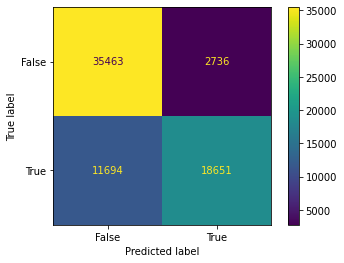

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

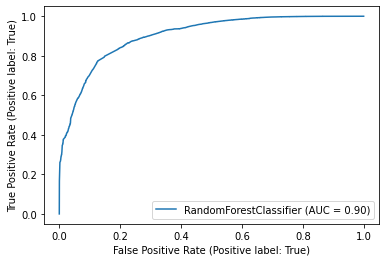

In [54]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(model, X_test, y_test.low_fat.astype(bool))

The classification model outperforms my expectations, with a reasonable (0.9) AUC and 78.98% accuracy. The biggest issue is a relatively large number of false negatives: perhaps better feature engineering will help identify additional factors that help define a low fat product.

#### Regression Model: Calories per Gram

In [55]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=4, random_state=0)
model.fit(X_train, y_train.calories_per_gram.astype(float))

RandomForestRegressor(max_depth=4, random_state=0)

In [56]:
y_pred = model.predict(X_test)
y_true = y_test.calories_per_gram.astype(float)

In [57]:
from sklearn.metrics import mean_absolute_error
print(f'Average error: {mean_absolute_error(y_true, y_pred)} calories per gram')

Average error: 0.4966428100883326 calories per gram


The current model seems to simply fit to the mean of the training set to minimize loss and doesn't really capture useful signal

In [58]:
# Manually inspect results
pd.DataFrame({'Actual': y_true, 'Predicted': y_pred}).sample(10)

,Actual,Predicted
13706,0.634012,0.579774
111447,0.797323,0.322703
210121,-1.352066,-1.161895
67964,1.782460,0.579774
160733,1.087069,0.579774
30122,0.691961,0.579774
42771,0.275780,0.579774
236257,0.091396,0.579774
1346,1.745583,0.579774
83737,-0.993835,-0.877616


Generally, the model seems to just predict the mean. Usually it will go higher or lower when appropriate, but it usually over or undershoots.

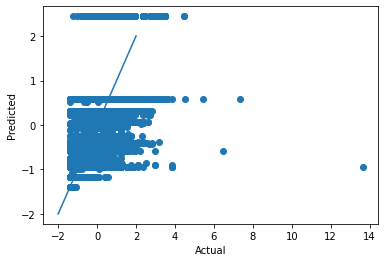

In [59]:
import numpy as np
plt.scatter(y_true, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
identity = np.linspace(-2, 2, 10)
plt.plot(identity, identity)

It's clear from this graphic that we're nowhere close to the identity line of perfect regression. Additionally, the model itself (random forest regressor) may just be a bad choice, since it buckets answers into one of a few different possible outputs, which don't capture nearly the whole range of outputs.

## Model Refinement
Setting aside the aspirational calorie regresser for now, we continue tuning the low fat classifier to try to maximize performance.

### Hyperparameter Tuning

In [60]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [61]:
# Data is relatively balanced, so no split stratification is needed

rf = RandomForestClassifier(random_state=0)
distributions = dict(max_depth=np.arange(2, 30, 1), n_estimators=np.arange(5, 100, 2))
rf_clf = RandomizedSearchCV(rf, distributions, random_state=0, n_iter=5, cv=3, verbose=4)
rf_search = rf_clf.fit(X, y.low_fat.astype(bool))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END .....max_depth=16, n_estimators=29;, score=0.846 total time=   9.1s
[CV 2/3] END .....max_depth=16, n_estimators=29;, score=0.836 total time=   8.3s
[CV 3/3] END .....max_depth=16, n_estimators=29;, score=0.836 total time=   9.0s
[CV 1/3] END .....max_depth=13, n_estimators=67;, score=0.818 total time=  14.4s
[CV 2/3] END .....max_depth=13, n_estimators=67;, score=0.799 total time=  14.4s
[CV 3/3] END .....max_depth=13, n_estimators=67;, score=0.817 total time=  14.6s
[CV 1/3] END .....max_depth=27, n_estimators=37;, score=0.874 total time=  14.8s
[CV 2/3] END .....max_depth=27, n_estimators=37;, score=0.870 total time=  14.8s
[CV 3/3] END .....max_depth=27, n_estimators=37;, score=0.870 total time=  14.5s
[CV 1/3] END .....max_depth=19, n_estimators=43;, score=0.857 total time=  13.3s
[CV 2/3] END .....max_depth=19, n_estimators=43;, score=0.846 total time=  13.5s
[CV 3/3] END .....max_depth=19, n_estimators=43;,

### Model Selection

In [62]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [63]:
# The full dataset has many datapoints to effectively train certain models (like SVM)
# Data beyond a relatively small number of samples has strongly diminishing
# returns on accuracy for these models, while also hitting compute limitations.
# (SVM memory scales quadratically, train time superlinearly)
# We construct a reduced sample set to train such models in a timely manner.
subset = X.sample(10000).index
X_reduced = X.loc[subset]
y_reduced = y.loc[subset]

In [64]:
svc = SVC(random_state=0)
distributions = dict(C=uniform(loc=0, scale=4), kernel=["linear", "poly", "rbf", "sigmoid"])
svc_clf = RandomizedSearchCV(svc, distributions, random_state=0, n_iter=5, cv=3, verbose=4)
svc_search = svc_clf.fit(X_reduced, y_reduced.low_fat.astype(bool))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END ..C=2.195254015709299, kernel=poly;, score=0.645 total time=   7.5s
[CV 2/3] END ..C=2.195254015709299, kernel=poly;, score=0.638 total time=   6.9s
[CV 3/3] END ..C=2.195254015709299, kernel=poly;, score=0.660 total time=   6.8s
[CV 1/3] END C=3.3770629943240693, kernel=sigmoid;, score=0.454 total time=   4.1s
[CV 2/3] END C=3.3770629943240693, kernel=sigmoid;, score=0.433 total time=   5.2s
[CV 3/3] END C=3.3770629943240693, kernel=sigmoid;, score=0.668 total time=   2.7s
[CV 1/3] END .C=2.1795327319875875, kernel=poly;, score=0.645 total time=   6.8s
[CV 2/3] END .C=2.1795327319875875, kernel=poly;, score=0.638 total time=   7.9s
[CV 3/3] END .C=2.1795327319875875, kernel=poly;, score=0.660 total time=   5.8s
[CV 1/3] END ..C=2.4942547871438894, kernel=rbf;, score=0.733 total time=   6.2s
[CV 2/3] END ..C=2.4942547871438894, kernel=rbf;, score=0.739 total time=   4.8s
[CV 3/3] END ..C=2.4942547871438894, kernel

In [65]:
gnb = GaussianNB()
distributions = dict(var_smoothing=uniform(loc=0, scale=0.001))
nb_clf = RandomizedSearchCV(gnb, distributions, random_state=0, n_iter=5, cv=3, verbose=4)
nb_search = nb_clf.fit(X, y.low_fat.astype(bool))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END var_smoothing=0.0005488135039273248;, score=0.527 total time=   2.3s
[CV 2/3] END var_smoothing=0.0005488135039273248;, score=0.558 total time=   3.4s
[CV 3/3] END var_smoothing=0.0005488135039273248;, score=0.552 total time=   2.2s
[CV 1/3] END var_smoothing=0.0007151893663724195;, score=0.522 total time=   2.1s
[CV 2/3] END var_smoothing=0.0007151893663724195;, score=0.551 total time=   2.1s
[CV 3/3] END var_smoothing=0.0007151893663724195;, score=0.547 total time=   2.1s
[CV 1/3] END var_smoothing=0.0006027633760716439;, score=0.526 total time=   2.2s
[CV 2/3] END var_smoothing=0.0006027633760716439;, score=0.556 total time=   3.5s
[CV 3/3] END var_smoothing=0.0006027633760716439;, score=0.551 total time=   2.3s
[CV 1/3] END var_smoothing=0.0005448831829968968;, score=0.528 total time=   2.1s
[CV 2/3] END var_smoothing=0.0005448831829968968;, score=0.558 total time=   2.1s
[CV 3/3] END var_smoothing=0.000544883

In [66]:
mlp = MLPClassifier(random_state=0, max_iter=500)
distributions = dict(hidden_layer_sizes=np.arange(20, 200, 10), activation=['tanh', 'relu', 'logistic'], solver=['lbfgs', 'adam', 'sgd'])
mlp_clf = RandomizedSearchCV(mlp, distributions, random_state=0, n_iter=5, cv=3, verbose=4)
mlp_search = mlp_clf.fit(X_reduced, y_reduced.low_fat.astype(bool))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3] END activation=relu, hidden_layer_sizes=60, solver=lbfgs;, score=0.811 total time=  15.1s


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3] END activation=relu, hidden_layer_sizes=60, solver=lbfgs;, score=0.822 total time=  21.3s


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3] END activation=relu, hidden_layer_sizes=60, solver=lbfgs;, score=0.823 total time=  14.9s


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=90, solver=sgd;, score=0.777 total time=  35.1s


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=90, solver=sgd;, score=0.792 total time=  35.9s


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=90, solver=sgd;, score=0.785 total time=  36.4s
[CV 1/3] END activation=logistic, hidden_layer_sizes=140, solver=adam;, score=0.838 total time=  45.4s
[CV 2/3] END activation=logistic, hidden_layer_sizes=140, solver=adam;, score=0.832 total time=  52.9s
[CV 3/3] END activation=logistic, hidden_layer_sizes=140, solver=adam;, score=0.844 total time=  48.0s
[CV 1/3] END activation=tanh, hidden_layer_sizes=40, solver=adam;, score=0.827 total time=  20.6s
[CV 2/3] END activation=tanh, hidden_layer_sizes=40, solver=adam;, score=0.825 total time=  30.0s
[CV 3/3] END activation=tanh, hidden_layer_sizes=40, solver=adam;, score=0.824 total time=  28.8s
[CV 1/3] END activation=tanh, hidden_layer_sizes=160, solver=sgd;, score=0.767 total time=  29.4s
[CV 2/3] END activation=tanh, hidden_layer_sizes=160, solver=sgd;, score=0.789 total time=  29.2s
[CV 3/3] END activation=tanh, hidden_layer_sizes=160, solver=sgd;, score=0.794 total time=  36.2s


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Despite increasing the number of iterations a fairly significant amount, it's difficult to get the MLP model to converge and many fail. However, the accuracy of the partially converged models remains fairly high. The warning about scaling the data is a red herring since our data is encoded as categorical values and scaling wouldn't make sense.

### Model Comparison

Of the four tested models (Random Forest, SVM, Naive Bayes, and MLP), Random Forest predictably seems to work best at about **87% accuracy**. This makes sense: Random Forest is well known for being naturally suited to categorical data, and this dataset is largely made up of simple categorical values. except for the single numerical field (serving size).

MLP (a single-layer neural net) also performed quite well, nearly reaching the accuracy of random forest. It's possible that with further careful tuning and more domain knowledge of how to tune sklearn's MLP implementation it would be possible to achieve higher accuracy. This is also unsurprising: MLPs are well known to be highly flexible models, also able to deal reasonably well with categorical data.

SVM and Naive Bayes were much less impressive. SVMs typically seem to perform better on continuous inputs, and the categorical-heavy input certainly isn't working in our favor here. I'm less sure about Naive Bayes, which I would have expected to perform quite well on this data. One possibility is that there are too many inputs with very different degrees of relevancy to our target output in our set of 101 features for Naive Bayes to set good priors and perform at its best. This might improve with more selective feature engineering.

### Business Feasibility

While a hypothetical business application is not extremely well defined for this model, it's worth thinking about these results critically and practically. 

The final results of about 87% accuracy are encouraging. Based on the confusion matrix, it seems like the model is able to identify key terms and ingredients that are almost always associated with being low fat, and will almost never label something low fat when it isn't. This emphasis on precision is a useful property if we were to apply this model as a pre-screening tool for low-fat testing. For example, as a food company, I could theoretically skip some expensive stages of internal testing if the model thought the food was low fat and send a sample for regulator examination, since the model is very unlikely to falsely call something low fat.

An important caveat, however, is that the model will certainly miss many low fat products - recall remains relatively low, and a high percentage of low-fat products as passed over. If I planned to apply this screening tool to identify which products I should push for low-fat certification, that would miss many opportunities to be certified - in such a case, a model with higher recall should be designed.